(-6.2913499999999996, 1.65835, 49.823949999999996, 59.41705)

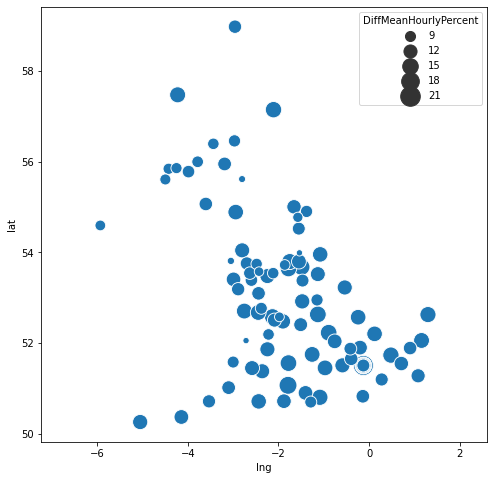

In [68]:
# Check UK Gender Pay Gap in the UK
# Datasets from:
# https://www.gov.uk/government/stat
# https://simplemaps.com/data/gb-cities

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Read the data
df = pd.read_csv('uk-pay-gap.csv')
post_code_to_region = pd.read_csv('postcode-area-to-name.csv')
city_to_coordinates = pd.read_csv('worldcities.csv')
city_to_coordinates_uk = city_to_coordinates[city_to_coordinates['country'] == 'United Kingdom']

pat = df["PostCode"].str.extract('([^[0-9]+)', expand = False)
grouped = df.groupby(pat)

data = grouped["DiffMeanHourlyPercent"].mean().sort_values(ascending=False)
data_filtered = data[data.index.isin(post_code_to_region["PostCode"])]
df_data = data_filtered.to_frame().merge(post_code_to_region, on="PostCode")

df_coordinates = df_data.merge(city_to_coordinates_uk, on = "city")
df_coordinates

plt = sns.scatterplot(x = "lng", y = "lat", data = df_coordinates, size = "DiffMeanHourlyPercent", sizes = (40, 400))
# plt = sns.barplot(y = df_data['Name'], x = df_data['DiffMeanHourlyPercent'])
# plt.set(title = 'Gender pay gap in the UK by city', xlabel='Gender pay gap (%)', ylabel='Postcode Area')
plt.figure.set_figheight(8)
plt.figure.set_figwidth(8)
plt.axis('equal')

In [ ]:
T